# Exploratory Data Analysis

In [ ]:
# Read DICOM image files
# ! pip install python-gdcm
# ! pip install pylibjpeg pylibjpeg-libjpeg pydicom

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# DICOM image files (.dcm)
import pydicom
from pydicom import dcmread

# NIfTI image files (.nii)
import nibabel as nib

## Introduction

**Origin**: The dataset we are using is made up of roughly 3000 CT studies, from twelve locations and across six continents. Spine radiology specialists have provided annotations to indicate the presence, vertebral level and location of any cervical spine fractures.

**Goal**: We need to predict the probability of fracture for each of the seven cervical vertebrae denoted by C1, C2, C3, C4, C5, C6 and C7 as well as an overall probability of any fractures in the cervical spine. Note that fractures in the skull base, thoracic spine, ribs, and clavicles are ignored.

**Metric evaluation**: The competition metric is a weighted multi-label logarithmic loss (averaged across all patients)

$ L_{ij} = - w_{ij} (y_{ij} \log (p_{ij}) + (1 - y_{ij}) \log (1 - p_{ij}))$

where the weights are given by 
$
w_{ij} = 
\begin{cases}
    1, \text{if vertebrae is negative}\\
    2, \text{if vertebrae is positive}\\
    7, \text{if patient is negative}\\
    14, \text{if patient is positive}
\end{cases}
$


**Input data** is composed of:
* *segmentations* (87 .nii files): A .nii file follows the Neuroimaging Informatics Technology Initiative (NIfTI) format(*)
* *train_images* (2019 folders of .dcm files) & *test_images* (3 folders of .dcm files): A .dcm file follows the Digital Imaging and Communications in Medicine (DICOM) format. It is the standard format used for storing medical images and related metadata
* *train.csv*: It contains metadata for train_images
* *test.csv*: It contains metadata for test_images
* *train_bounding_boxes.csv*: It contains bounding boxes of where fractures occured for a subset of the training set
* *sample_submission.csv*: A valid sample submission


(*)A nibabel (and nipy) image is the association of three things:
* The image data array: a 3D or 4D array of image data
* An affine array that tells you the position of the image array data in a reference space.
* image metadata (data about the data) describing the image, usually in the form of an image header.

## Data

In [2]:
# Load data
train_df = pd.read_csv('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train.csv')
train_bbox = pd.read_csv('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv')
test_df = pd.read_csv('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test.csv')
ss = pd.read_csv('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv')

In [3]:
# Dataframe shape
print('train_df shape:', train_df.shape)
print('train_bbox shape:', train_bbox.shape)
print('test_df shape:', test_df.shape)
print('ss shape:', ss.shape)

train_df shape: (2019, 9)
train_bbox shape: (7217, 6)
test_df shape: (3, 3)
ss shape: (3, 2)


### train.csv
* StudyInstanceUID - The study ID. There is one unique study ID for each patient scan.
* patient_overall - The patient level outcome, i.e. if any of the vertebrae are fractured.
* C[1-7] - Whether the given vertebrae is fractured.

In [4]:
train_df.head(5)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


### train_bounding_boxes.csv
* StudyInstanceUID - The study ID. There is one unique study ID for each patient scan.
* x - x-coordinate of bounding box bottom left corner
* y - y-coordinate of bounding box bottom left corner
* width - width of bounding box
* height - height of bounding box
* slice_number - slice number of scan

NB. We only have bounding boxes for a subset of the training set.

In [5]:
train_bbox.head(5)

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


In [6]:
train_bbox['StudyInstanceUID'].nunique()

235

### test.csv
* row_id - The row ID. This will match the same column in the sample submission file.
* StudyInstanceUID - The study ID.
* prediction_type - Which one of the eight target columns needs a prediction in this row.

In [7]:
test_df.head()

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


### sample_submission.csv
* row_id - The row ID. See the test.csv for what prediction needs to be filed in that row.
* fracture - The target column.

In [8]:
ss.head()

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


## Exploratory Data Analysis

**Fractures by overall patients**: 52% (zero-target) and 48% (one-target).

**Fractures by vertebrae**:
* C1: 93% (zero-target) and 7% (one-target)
* C2: 86% (zero-target) and 14% (one-target)
* C3: 96% (zero-target) and 4% (one-target) --> Lowest fractured rate among single vertebrae
* C4: 95% (zero-target) and 5% (one-target)
* C5: 92% (zero-target) and 8% (one-target)
* C6: 86% (zero-target) and 14% (one-target)
* C7: 80% (zero-target) and 20% (one-target) --> Highest fractured rate among single vertebrae 

(0.0, 2800.0)

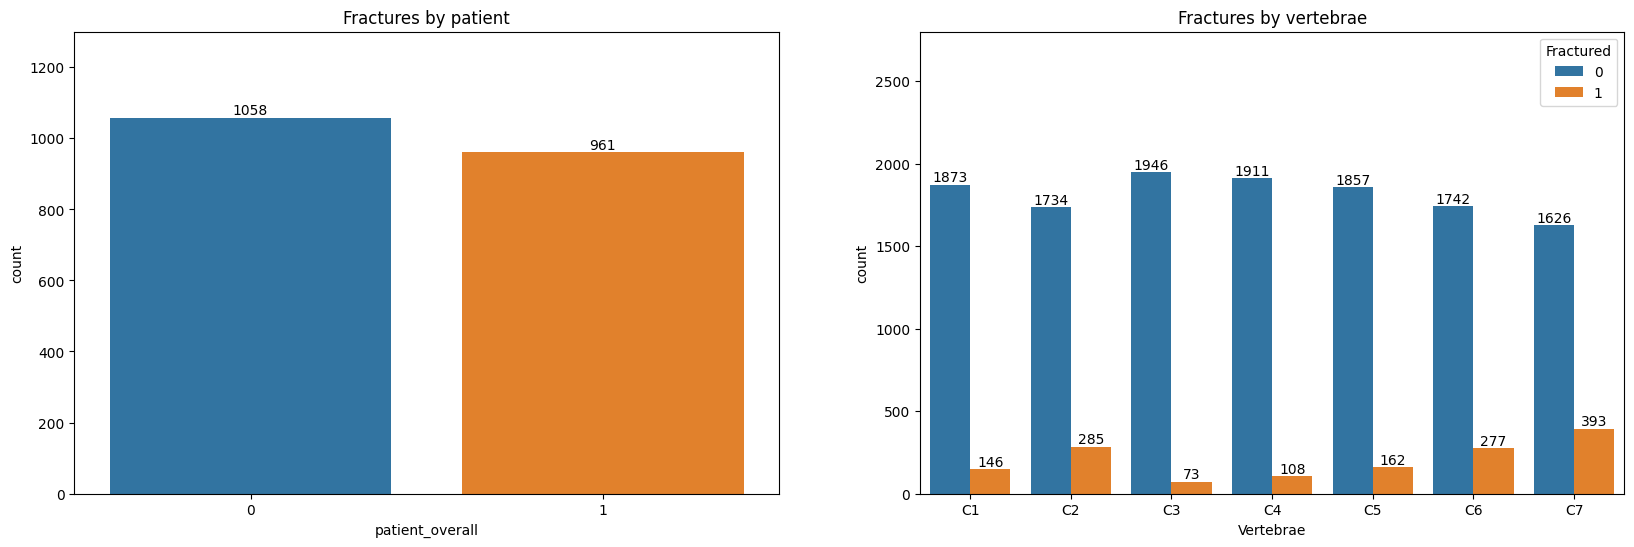

In [9]:
# Plotting num of fractures by patients
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])

# Temp df
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

# Plotting num of fractures by vertebrae
plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])

**Number of fractures by patient**: Large part of patients have more than one fractures

(0.0, 1300.0)

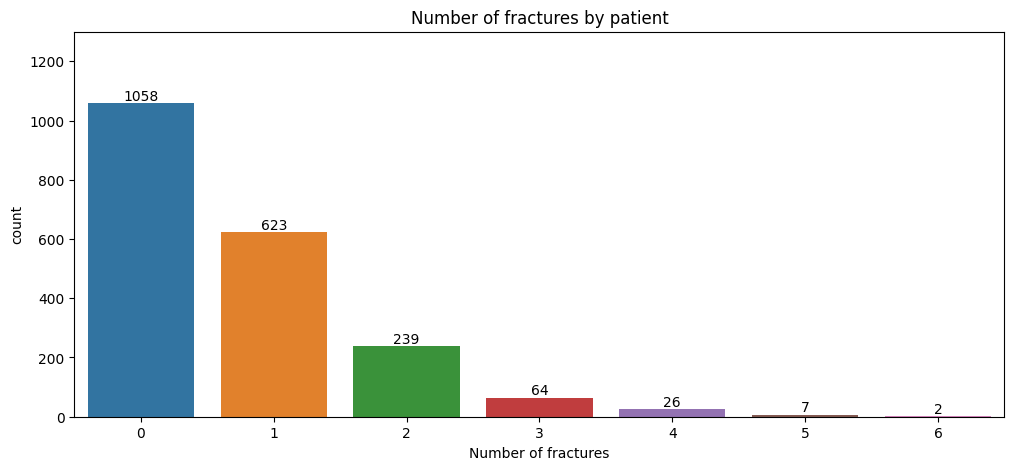

In [10]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')
plt.ylim([0,1300])

**Correlations fractures**: Multiple fractures within a single patient mostly occur between two closely adjacent vertebrae.

Text(0.5, 1.0, 'Correlations')

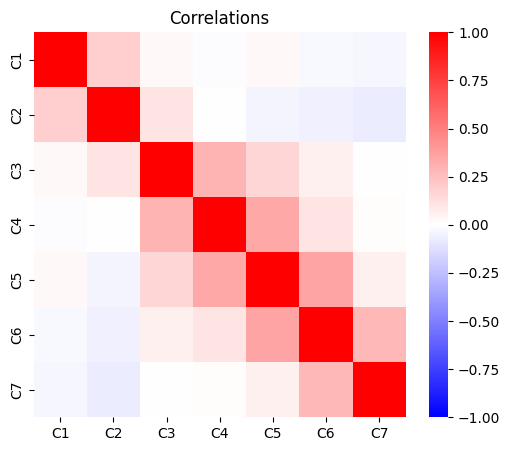

In [11]:
plt.figure(figsize=(6,5))
sns.heatmap(train_df[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlations')

## Train Images
We use the *pydicom* library to open and explore .dcm files.

By using *dcmread()*, we get 4 data values: PatientID (== PatientName), ImagePositionPatient, ImageOrientationPatient.

NB. ImagePositionPatient: array of three values, ie position of patient on x-axis, y-axis and z-axis (ie position in sagittal plane)

In [12]:
image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10921/100.dcm'
ds = dcmread(image_path)
ds

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10921.1.100
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10921.1.100
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '182424.000025'
(0010, 0010) Patient's Name                      PN: '10921'
(0010, 0020) Patient ID                          LO: '10921'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

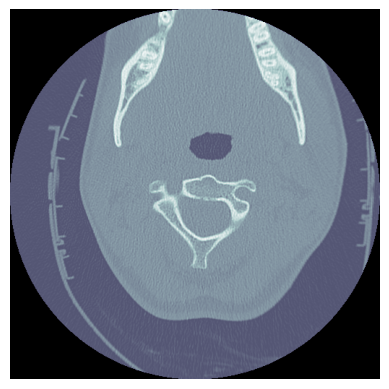

In [13]:
# Example dicom 10921
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.axis('off')
plt.show()

## Bounding boxes

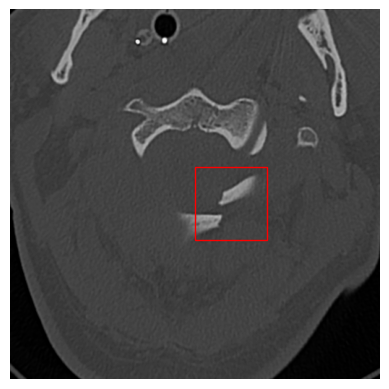

In [14]:
# Plot image with bounding box of the fracture
study_instance = train_bbox.iloc[100]

UID = study_instance['StudyInstanceUID']

slice_number = study_instance ['slice_number']

image_path = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/' + UID + f'/{slice_number}.dcm'

# Bounding boxes
x = study_instance['x']
y = study_instance['y']
w = study_instance['width']
h = study_instance['height']

# read the DICOM file from train_images
ds = dcmread(image_path)

# Plot the DICOM image with the bounding box
fig, ax = plt.subplots()
ax.imshow(ds.pixel_array, cmap=plt.cm.gray)
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()

## Segmentations
To open .nii files we use the *nibabel* library.

By using the command *get_fdata()*, we get an array of (height, width, num_images) --> after reshaping array is (num_images, height, width).

NB. num_images == number of dicom files in patient subfolder of train_images.

In [15]:
segmentations = nib.load('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.10921.nii').get_fdata()[:, ::-1, ::-1].transpose(2, 1, 0)
segmentations

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [16]:
# Affine array
nib.load('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.10921.nii').affine

array([[  -0.33203101,   -0.        ,    0.        ,   67.40000153],
       [  -0.        ,    0.33203101,   -0.        ,  -84.66783905],
       [   0.        ,    0.        ,    0.625     , -210.25      ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [17]:
# Image header (metadata)
print(nib.load('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.10921.nii').header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 339   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.        0.332031  0.332031  0.625     0.        0.        0.
  0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : aligned
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 67.4
qoffset_y       : -84.66784
qoffset_z       : 

In [18]:
# Get bone number: slice number refer to image_num.dcm
# Array output: 0. refers to background, 2. refers to bone number (ie C2)
np.unique(segmentations[99])

array([0., 2.])

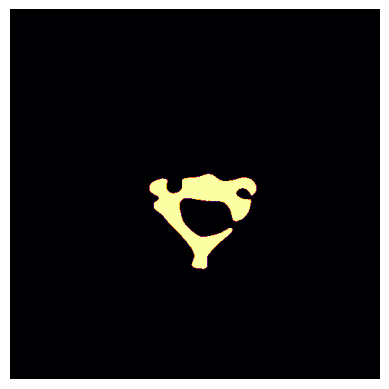

In [19]:
# Example nifti 10921 (slice 99 --> 100.dcm): Bone number C2
plt.imshow(segmentations[99], cmap=plt.cm.inferno)
plt.axis('off')
plt.show()

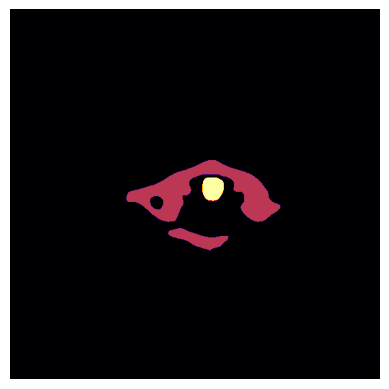

In [20]:
# Example nifti 10921 (slice 69 --> 70.dcm): Bone numbers: C1 C2
plt.imshow(segmentations[69], cmap=plt.cm.inferno)
plt.axis('off')
plt.show()

[0.]


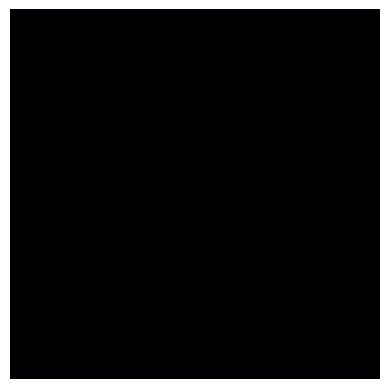

[0. 8. 9.]


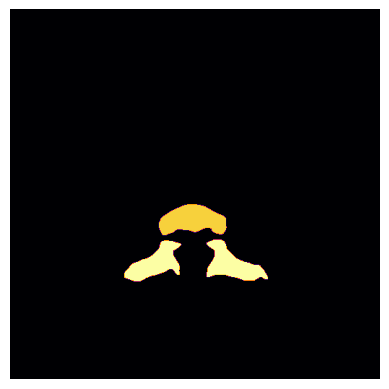

In [21]:
# Examples to discard
i = 51
print(np.unique(segmentations[i]))
plt.imshow(segmentations[i], cmap=plt.cm.inferno)
plt.axis('off')
plt.show()

i = 269
print(np.unique(segmentations[i]))
plt.imshow(segmentations[i], cmap=plt.cm.inferno)
plt.axis('off')
plt.show()

In [22]:
for i in range(0, len(segmentations)):
    if len(np.unique(segmentations[i])) > 1:
        print(f'num_image: {i+1}.dcm, bone number:',np.unique(segmentations[i])[1:])

num_image: 53.dcm, bone number: [1.]
num_image: 54.dcm, bone number: [1.]
num_image: 55.dcm, bone number: [1.]
num_image: 56.dcm, bone number: [1.]
num_image: 57.dcm, bone number: [1.]
num_image: 58.dcm, bone number: [1.]
num_image: 59.dcm, bone number: [1.]
num_image: 60.dcm, bone number: [1.]
num_image: 61.dcm, bone number: [1. 2.]
num_image: 62.dcm, bone number: [1. 2.]
num_image: 63.dcm, bone number: [1. 2.]
num_image: 64.dcm, bone number: [1. 2.]
num_image: 65.dcm, bone number: [1. 2.]
num_image: 66.dcm, bone number: [1. 2.]
num_image: 67.dcm, bone number: [1. 2.]
num_image: 68.dcm, bone number: [1. 2.]
num_image: 69.dcm, bone number: [1. 2.]
num_image: 70.dcm, bone number: [1. 2.]
num_image: 71.dcm, bone number: [1. 2.]
num_image: 72.dcm, bone number: [1. 2.]
num_image: 73.dcm, bone number: [1. 2.]
num_image: 74.dcm, bone number: [1. 2.]
num_image: 75.dcm, bone number: [1. 2.]
num_image: 76.dcm, bone number: [1. 2.]
num_image: 77.dcm, bone number: [1. 2.]
num_image: 78.dcm, bone 